In [2]:
import os
import torch
import pandas as pd
import numpy as np
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import os.path as osp
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
from CLGraph.CLGraph import CLGraph

In [3]:
os.environ['R_HOME'] = '/home/dsj/anaconda3/envs/dsjtrain/lib/R'

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<h4>Input</h4>

In [6]:
# the number of clusters
# 151507/151508/151509/151510: 7
# 151669/151670/151671/151672: 5
# 151673/151674/151675/151676: 7
dataset = '151674'
n_clusters = 7

file_fold = '/home/isaac/dev/sfu/cmpt415/DeepST/data/DLPFC/' + str(dataset)

adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
adata

/tmp/ipykernel_7820/1699791673.py:10: FutureWarning: Use `squidpy.read.visium` instead.
  adata = sc.read_visium(file_fold, count_file='filtered_feature_bc_matrix.h5', load_images=True)
/home/isaac/dev/sfu/cmpt415/CLGraph/CLGraph/clgraph/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/isaac/dev/sfu/cmpt415/CLGraph/CLGraph/clgraph/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3673 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
# image features
feature = np.load(os.path.join(file_fold, 'embeddings.npy'))
feature = feature.reshape(feature.shape[0], -1)

# Standardize and apply PCA
scaler = StandardScaler()
pic_feature = scaler.fit_transform(feature)
pca = PCA(n_components=20, random_state=42)
pic_feature = pca.fit_transform(pic_feature)
adata.obsm['pic_feature'] = pic_feature

<h4>Train</h4>

In [9]:
# define model
model = CLGraph(adata, image=True, device=device)

# train model
adata = model.train()

Begin to train ST data...


100%|█████████████████████████████████████████| 600/600 [00:13<00:00, 45.19it/s]


Optimization finished for ST data!


In [10]:
adata

AnnData object with n_obs × n_vars = 3673 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p'
    obsm: 'spatial', 'pic_feature', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'pic_distance_matrix', 'pic_graph_neigh', 'pic_adj', 'emb'

In [11]:
adata.obsm['label_CSL']


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], shape=(3673, 2))

<h4>Clustering</h4>

In [15]:
# add ground_truth
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['ground_truth'] = df_meta_layer.values
df_meta_layer


AAACAAGTATCTCCCA-1    Layer3
AAACAATCTACTAGCA-1    Layer1
AAACACCAATAACTGC-1        WM
AAACAGAGCGACTCCT-1    Layer3
AAACAGCTTTCAGAAG-1    Layer5
                       ...  
TTGTTTCACATCCAGG-1        WM
TTGTTTCATTAGTCTA-1        WM
TTGTTTCCATACAACT-1    Layer6
TTGTTTGTATTACACG-1        WM
TTGTTTGTGTAAATTC-1    Layer1
Name: layer_guess, Length: 3673, dtype: object

In [16]:
# set radius to specify the number of neighbors considered during refinement
radius = 50

tool = 'louvain' # mclust, leiden, and louvain

# clustering
from CLGraph.utils import clustering

if tool == 'mclust':
   clustering(adata, n_clusters, radius=radius, method=tool, refinement=True) # For DLPFC dataset, we use optional refinement step.
elif tool in ['leiden', 'louvain']:
   clustering(adata, n_clusters, radius=radius, method=tool, start=0.1, end=2.0, increment=0.01, refinement=True)

Searching resolution...


/home/isaac/dev/sfu/cmpt415/CLGraph/CLGraph/clgraph/lib/python3.12/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


resolution=1.989999999999999, cluster number=15
resolution=1.979999999999999, cluster number=15
resolution=1.969999999999999, cluster number=15
resolution=1.959999999999999, cluster number=14
resolution=1.949999999999999, cluster number=14
resolution=1.939999999999999, cluster number=14
resolution=1.9299999999999993, cluster number=14
resolution=1.9199999999999993, cluster number=15
resolution=1.9099999999999993, cluster number=14
resolution=1.8999999999999992, cluster number=14
resolution=1.8899999999999992, cluster number=14
resolution=1.8799999999999992, cluster number=14
resolution=1.8699999999999992, cluster number=14
resolution=1.8599999999999992, cluster number=14
resolution=1.8499999999999992, cluster number=14
resolution=1.8399999999999992, cluster number=14
resolution=1.8299999999999992, cluster number=14
resolution=1.8199999999999992, cluster number=14
resolution=1.8099999999999992, cluster number=14
resolution=1.7999999999999992, cluster number=14
resolution=1.7899999999999

In [17]:
# filter out NA nodes
adata = adata[~pd.isnull(adata.obs['ground_truth'])]

# calculate metric ARI
ARI = metrics.adjusted_rand_score(adata.obs['domain'], adata.obs['ground_truth'])
adata.uns['ARI'] = ARI

print('Dataset:', dataset)
print('ARI:', ARI)

/tmp/ipykernel_7820/1302746772.py:6: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['ARI'] = ARI


Dataset: 151674
ARI: 0.4362978745559422


/tmp/ipykernel_7820/581208093.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata,


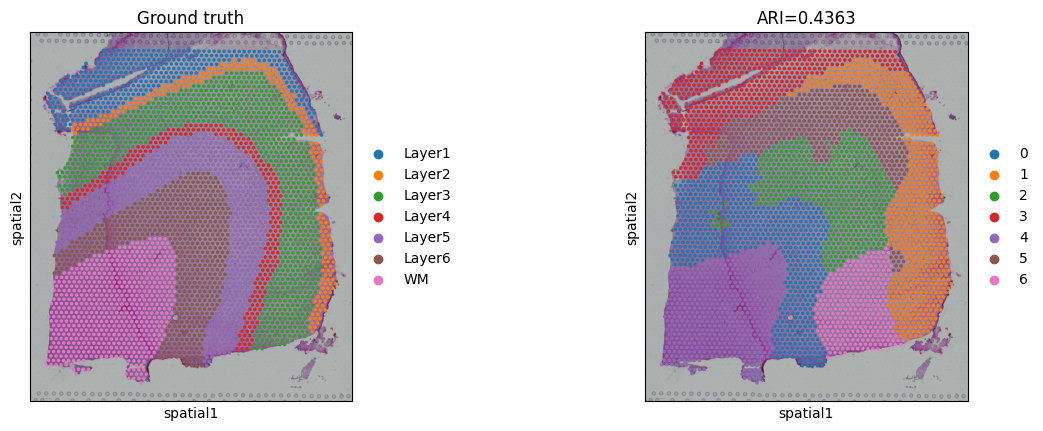

In [18]:
# plotting spatial clustering result
sc.pl.spatial(adata,
              img_key="hires",
              color=["ground_truth", "domain"],
              title=["Ground truth", "ARI=%.4f"%ARI],
              show=True)

In [24]:
adata.obs['domain'].reset_index().to_csv(f"{dataset}_MISC3_clgraph.csv",index=False,header=["Barcode","Cluster"])

<h4>SVG</h4>

In [19]:
adata_gene = adata[:, adata.var['highly_variable']]
adata_gene

View of AnnData object with n_obs × n_vars = 3635 × 3000
    obs: 'in_tissue', 'array_row', 'array_col', 'ground_truth', 'louvain', 'domain'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'spatial', 'hvg', 'log1p', 'neighbors', 'louvain', 'ARI', 'ground_truth_colors', 'domain_colors'
    obsm: 'spatial', 'pic_feature', 'distance_matrix', 'graph_neigh', 'adj', 'label_CSL', 'feat', 'feat_a', 'pic_distance_matrix', 'pic_graph_neigh', 'pic_adj', 'emb', 'emb_pca'
    obsp: 'distances', 'connectivities'

/home/isaac/dev/sfu/cmpt415/CLGraph/CLGraph/clgraph/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:667: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


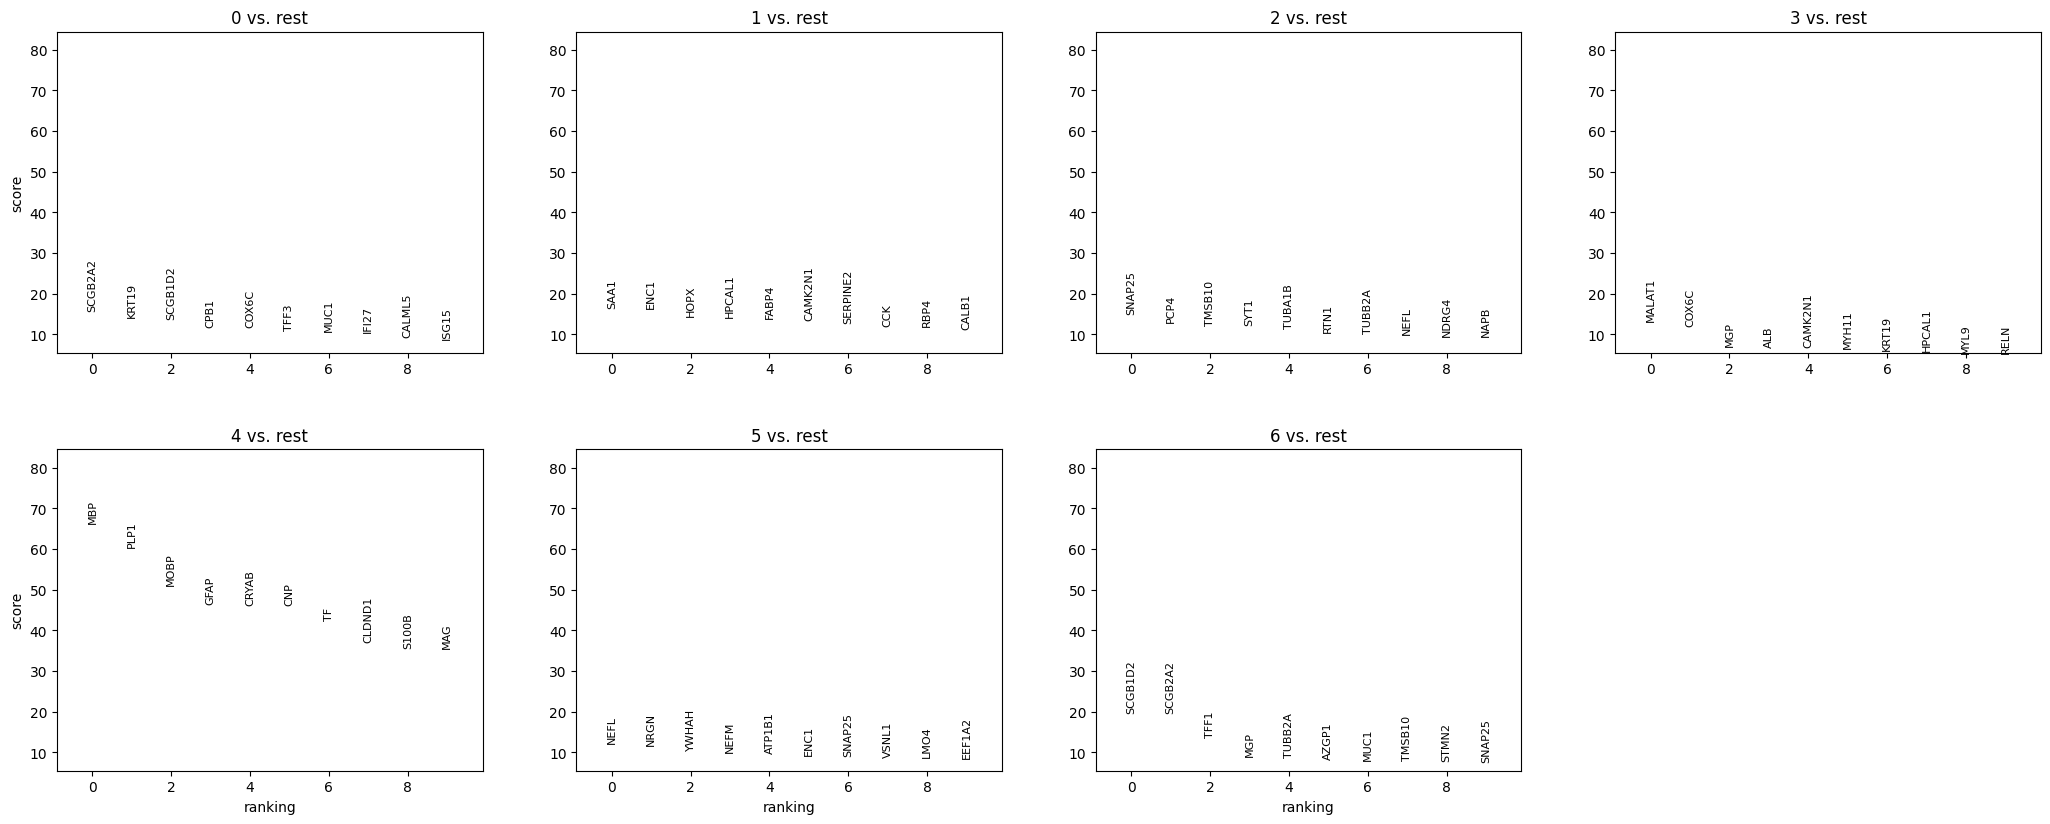

In [20]:
n_genes=10

sc.tl.rank_genes_groups(adata_gene, 'domain', method='t-test_overestim_var')
sc.pl.rank_genes_groups(adata_gene, groupby='domain', method='t-test_overestim_var', n_genes=n_genes)

In [21]:
top_genes = pd.DataFrame(adata_gene.uns['rank_genes_groups']['names']).iloc[:n_genes, :].values.flatten()
adata_gene_ = adata_gene[:, top_genes].X.toarray()[:, ]
z_scores = (adata_gene_ - np.mean(adata_gene_, axis=0)) / np.std(adata_gene_, axis=0)
adata_clgraph = sc.AnnData(X=z_scores, obs=adata.obs, var=adata.var.loc[top_genes])

/home/isaac/dev/sfu/cmpt415/CLGraph/CLGraph/clgraph/lib/python3.12/site-packages/anndata/_core/anndata.py:1776: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


dendrogram data not found (using key=dendrogram_domain). Running `sc.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `sc.tl.dendrogram` independently.
/home/isaac/dev/sfu/cmpt415/CLGraph/CLGraph/clgraph/lib/python3.12/site-packages/scanpy/tools/_dendrogram.py:138: UserWarning: You’re trying to run this on 70 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  _choose_representation(adata, use_rep=use_rep, n_pcs=n_pcs)


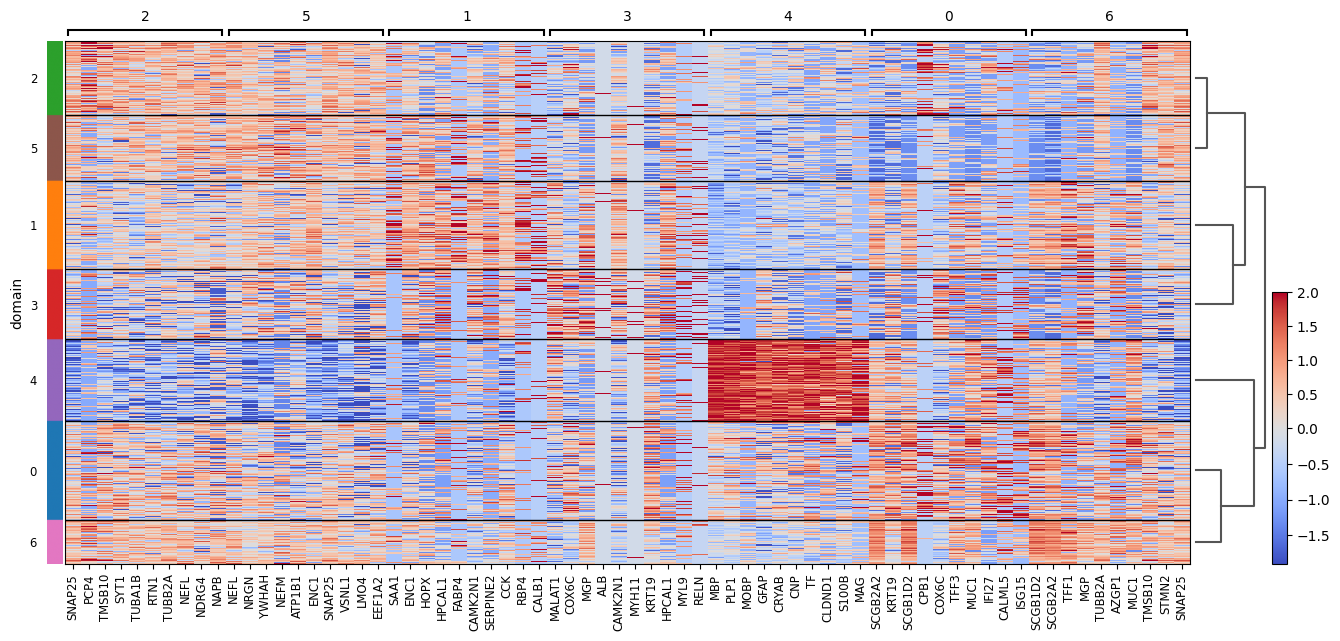

In [22]:
# adata_clgraph.uns['dendrogram_label'] = adata.uns['dendrogram_label']
adata_clgraph.uns['rank_genes_groups'] = adata_gene.uns['rank_genes_groups']
adata_clgraph.var_names_make_unique()
# sc.pl.heatmap(adata_proust, groupby='label', var_names=top_genes)
sc.pl.rank_genes_groups_heatmap(adata_clgraph, n_genes=n_genes, show_gene_labels=True, figsize=(16, 7), show=True, cmap="coolwarm", vmin=-1.9, vmax=2, vcenter=0)
plt.show()

In [17]:
# sc.tl.filter_rank_genes_groups(adata_clgraph, min_fold_change=0.01)
markers = []
temp = pd.DataFrame(adata_clgraph.uns['rank_genes_groups']['names']).head(5)
for i in range(temp.shape[1]):
    curr_col = temp.iloc[:, i].to_list()
    markers.append(curr_col)
    
print(markers)

[['NEFL', 'NEFM', 'NRGN', 'YWHAH', 'LMO4'], ['ENC1', 'HPCAL1', 'SERPINE2', 'CAMK2N1', 'HOPX'], ['MALAT1', 'COX6C', 'MGP', 'MYH11', 'KRT19'], ['PCP4', 'TMSB10', 'SNAP25', 'TUBB2A', 'TUBA1B'], ['MBP', 'PLP1', 'MOBP', 'GFAP', 'CRYAB'], ['SCGB2A2', 'SCGB1D2', 'CPB1', 'KRT17', 'KRT19'], ['SAA1', 'FABP4', 'G0S2', 'RBP4', 'CFD']]


In [18]:
adata_SVG = adata.X.toarray()[:, ]
category = 3
gene_list = markers[category-1]

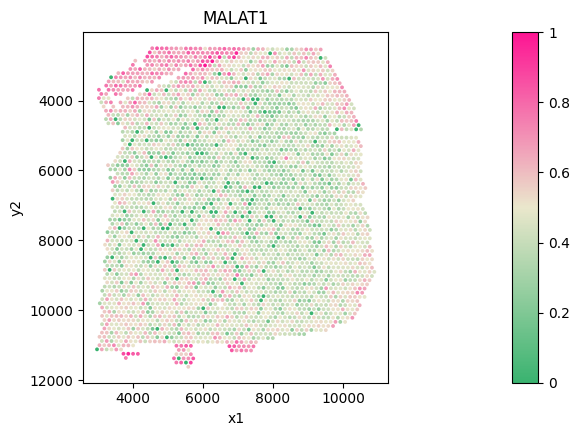

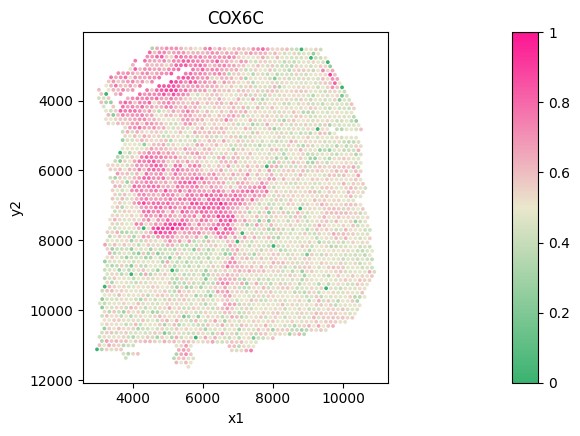

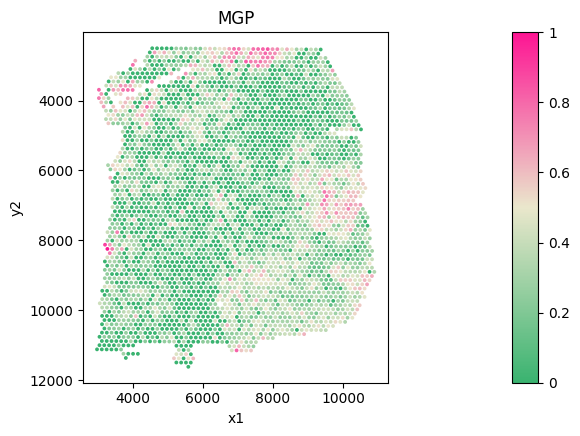

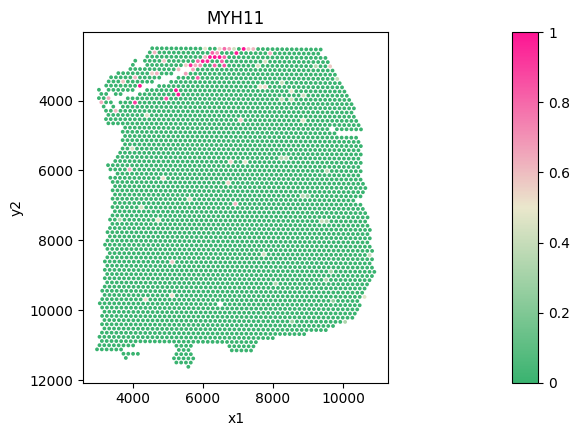

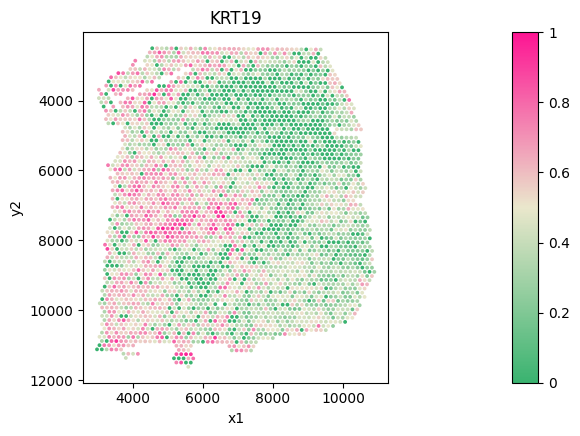

In [19]:
import matplotlib.colors as clr
color_self = clr.LinearSegmentedColormap.from_list('pink_green', ['#3AB370',"#EAE7CC","#FD1593"], N=256)

position = adata.obsm['spatial']
adata.obs['x1'] = position[:, 0]
adata.obs['y2'] = position[:, 1]

# plt.rcParams["figure.figsize"] = (4, 4)
for g in gene_list:
    adata.obs["exp"]=adata_SVG[:,adata.var.index==g]
    max = adata.obs['exp'].max()
    adata.obs["exp"] = adata.obs["exp"].tolist()/max
    ax = sc.pl.scatter(adata,
                       alpha=1,
                       title = g,
                       x='x1', y='y2',
                       color="exp",
                       size = 30,
                       legend_fontsize=20,
                       # frameon = False,
                       color_map=color_self,
                       show=False)
    
    ax.set_aspect('equal', 'box')
    ax.axes.invert_yaxis()
    plt.show()
    plt.close()